#  Learning to Solve Binary Integer Programming via Hypergraph Neural Networks

First of all, ensure you can import our main code `src`:

In [1]:
import torch
import sys
from pathlib import Path

sys.path.append(str(Path().resolve().parent))

import src
from src import init, get_device
init(cuda_index=0, reproducibility=True)

c:\Users\keaix\miniconda3\envs\bpgcn\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[DEBUG] matplotlib data path: c:\Users\keaix\miniconda3\envs\bpgcn\lib\site-packages\matplotlib\mpl-data
[DEBUG] CONFIGDIR=C:\Users\keaix\.matplotlib
[DEBUG] interactive is False
[DEBUG] platform is win32
[DEBUG] CACHEDIR=C:\Users\keaix\.matplotlib
[DEBUG] font search path [WindowsPath('c:/Users/keaix/miniconda3/envs/bpgcn/lib/site-packages/matplotlib/mpl-data/fonts/ttf'), WindowsPath('c:/Users/keaix/miniconda3/envs/bpgcn/lib/site-packages/matplotlib/mpl-data/fonts/afm'), WindowsPath('c:/Users/keaix/miniconda3/envs/bpgcn/lib/site-packages/matplotlib/mpl-data/fonts/pdfcorefonts')]
[INFO] generated new fontManager
[WARNING] You have enabled the reproducibility feature, which uses a deterministic non-optimized algorithm, greatly affe

> If you can't, don't worry, this notebook already includes the running results of all the code :)

## Binary Integer Programming

So *`Binary Integer Programming`* can be simply described as a polynomial with variable values limited to {0,1} and is usually subject to constraints like this:

\begin{equation}
\begin{aligned}
    & {\color{green}\min} \quad -x_1 - \sin(x_1x_2) + x_3x_4 + 2x_4 \tag{1}\\
    & {\color{red}\text{s.t.}} \quad 2x_1 + e^{x_2} + 3x_1x_3 \leq 5 \\
    & \qquad \quad\ \, x_i \in \{0, 1\}, \quad i = 1, 2, 3, 4 \nonumber
\end{aligned}
\end{equation}

We want to solve this kind of problem through deep learning. In deep learning, the variables are in a **continuous space**, so after $\lbrace 0,1 \rbrace$ is transformed to the interval $[0,1]$, the above problem can be linearly approximated to:

\begin{equation}
\begin{aligned}
    & {\color{green}\min} \quad -x_1 - 0.8451\,x_1x_2 + x_3x_4 + 2x_4 \\
    & {\color{red}\text{s.t.}} \quad 2x_1 + 1.7183\,x_2 + 3x_1x_3 \leq 4 \tag{2} \\
    & \qquad \quad\ \, x_i \in \{0, 1\}, \quad i = 1, 2, 3, 4
\end{aligned}
\end{equation}

## Use Hypergraph neural network to solve PUBO Problem

### Describing Polynomials by Hypergraph

Let's start by excluding constraints, For optimization target:
$$ {\color{green}\min} \quad -x_1 - 0.8451\,x_1x_2 + x_3x_4 + 2x_4 $$
The terms in the polynomial excluding the coefficients can be represented by a **Incidence matrix**:


| 🫡     | $p_1$  | $p_2$  | $p_3$  | $p_4$  |
| :----: | :----: | :----: | :----: | :----: |
| $x_1$  | 1      | 1      | 0      | 0      |
| $x_2$  | 0      | 1      | 0      | 0      |
| $x_3$  | 0      | 0      | 1      | 0      |
| $x_4$  | 0      | 0      | 1      | 1      |

This matrix can easily represent a term in a polynomial, for example: if there exists a term $p_5 :  x_1 x_2 x_3 x_4 $  , the **Incidence matrix** would be:

| 🤔     | $p_1$  | $p_2$  | $p_3$  | $p_4$  | $p_5$  |
| :----: | :----: | :----: | :----: | :----: | :----: |
| $x_1$  | 1      | 1      | 0      | 0      | 1      |
| $x_2$  | 0      | 1      | 0      | 0      | 1      |
| $x_3$  | 0      | 0      | 1      | 0      | 1      |
| $x_4$  | 0      | 0      | 1      | 1      | 1      |

Another application of the incidence matrix is ​​that it can represent a **hypergraph** structure ! In mathematics, a **hypergraph** is a generalization of a graph in which an edge can join any number of vertices. An example of an undirected hypergraph, with  $X = \lbrace v_1, v_2, v_3, v_4, v_5, v_6, v_7 \rbrace$ and $E = \lbrace e_1, e_2, e_3, e_4 \rbrace = \lbrace \lbrace v_1, v_2, v_3 \rbrace, \lbrace v_2, v_3 \rbrace, \lbrace v_3, v_5, v_6 \rbrace , \lbrace v_4 \rbrace \rbrace$, the hypergraph can 
 be represented by a incidence matrix:

| 🤓     | $e_1$  | $e_2$  | $e_3$  | $e_4$  |
| :----: | :----: | :----: | :----: | :----: | 
| $v_1$  | 1      | 0      | 0      | 0      | 
| $v_2$  | 1      | 1      | 0      | 0      |
| $v_3$  | 1      | 1      | 1      | 0      |
| $v_4$  | 0      | 0      | 0      | 1      |
| $v_5$  | 0      | 0      | 1      | 0      |
| $v_6$  | 0      | 0      | 1      | 0      |
| $v_7$  | 0      | 0      | 0      | 0      |

So here comes the magic, we can use a hypergraph structure to represent a polynomial, and they are connected using an **incidence matrix**. In the field of graph neural networks, there are already many excellent hypergraph neural networks such as HyperGCN and HGNN. We can use them to input polynomial information into the neural network.

Use the terms in the polynomial as the hyperedges of the target hypergraph. Obviously, the coefficients of the terms are used as the weights of the corresponding hyperedges:

In [2]:
from dhg import Hypergraph  # use basic lib `DHG 0.9.4`

terms = [(0,), (0, 1), (2, 3), (3,)]  # terms of polynomial by Eq. (2)
coefficients = [-1, -0.8451, 1, 2]  # don't forget the coefficients of the terms
# here we have the hypergraph structure corresponding to the target polynomial
data = Hypergraph(num_v=4, e_list=terms, e_weight=coefficients).to(get_device()) 

### Define Hypergraph Neural Network

Then define the structure of Hypergraph neural network, in `src/models`, there are many different Layers available to choose from:

In [3]:
from src import Layer, LayerType, Net

layers = [Layer(LayerType.HGNNPCONV, 128, 64),  # Use HGNNP Layers to collect information
          Layer(LayerType.LINEAR, 64, 1)]        # Use Linear Layers for node state selection
net = Net(layers)

### Define PUBO Loss Formula Standard Form

The previous article introduced how to use hypergraph to describe a polynomial, but how to describe the calculation corresponding to the polynomial?

The column of the **incidence matrix** shows whether the variable exists in the term, so we can calculate the polynomial term by term, which is reflected in the **incidence matrix** by column by column. First, we mark the output of the model, if the variable exists in the term, the corresponding model's output remains the original value. Otherwise, it is set to `1` to generate Marked-Output, and then multiply it element by element, and finally multiply it by the coefficient corresponding to the term. In this way, the calculation is carried out column by column until all the variables are completed.

> Setting values to 1 signifies that the model outputs corresponding to variables not present in the current term do not participate in the computation of that term—for multiplication, it is treated as multiplying by 1, and for addition, as adding 0.

> It can be associated that calculating the polynomial term by term is actually calculating the corresponding hypergraph structure hyperedge by hyperedge

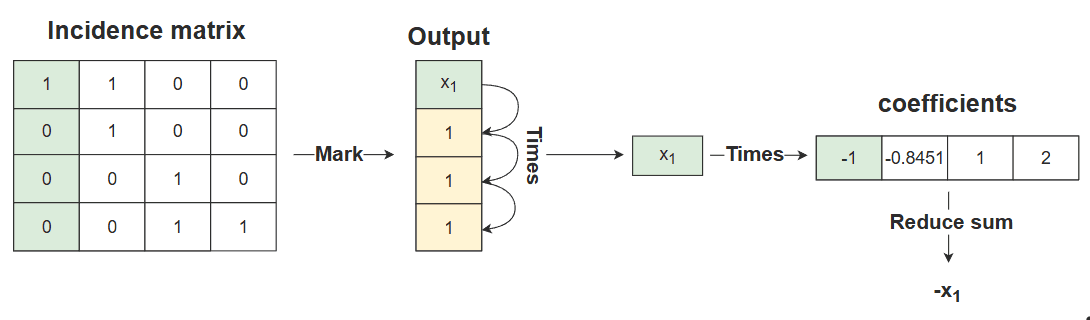

You can see the terms of a polynomial do not have computational dependencies on each other, so we can use the terms as `work` and perform efficient **parallel computation** using modern hardware devices, which uses the incidence matrix corresponding to the polynomial for efficient matrix operations. We defined a PUBO polynomial computation function `loss_pubo` in `src/loss.py`.

### run task

 Everything is ready! We can start the pubo task now:

In [4]:
from src import loss_pubo, run

H = data.H.to_dense()               # 'H' is Incidence matrix, which relates the polynomial to its corresponding hypergraph structure
C = torch.tensor(data.e[1])         # 'C' is a polynomial coefficient Vector and is equivalent to `torch.tensor(coefficients)`
X = torch.rand(data.num_v, 128)     # model input
loss, outs = run(layers, X, data, 1000, loss_pubo, 1e-3, H=H, C=C)
print(f"\n\033[92moutput:{list(outs.cpu().squeeze().detach().numpy())}\033[0m")

 22%|██▏       | 216/1000 [00:03<00:07, 104.98it/s]

epoch: 200: loss:-1.76 | annl: 1.24


 41%|████      | 407/1000 [00:05<00:05, 112.14it/s]

epoch: 400: loss:-1.82 | annl: 1.06


 61%|██████    | 611/1000 [00:07<00:03, 105.32it/s]

epoch: 600: loss:-1.83 | annl: 1.02


 81%|████████  | 809/1000 [00:09<00:01, 107.24it/s]

epoch: 800: loss:-1.84 | annl: 1.00


100%|██████████| 1000/1000 [00:10<00:00, 90.96it/s]

epoch: 1000: loss:-1.84 | annl: 0.99

output:[0.9992286, 0.99838126, 0.56647134, 0.0005423969]


> It is worth noting that in the *Binary integer programming problem*, there is a prerequisite constraint that the values of the variables are all $\lbrace 0, 1 \rbrace$. We can achieve this by using ***Sigmoid*** in the last layer of our model.

As you can see we get a pretty good result, but unfortunately not all variables converge to $ \lbrace 0, 1 \rbrace $ as we expected 🤔, and you can observe that we have a loss named 'annl' that does not converge to $0$, This is the **Annealing strategy** algorithm we mentioned in our paper, which you can read in more detail in sections 3.2 and 6.4. In the code, we can pass a lambda expression to `loss_pubo` to enable the annealing strategy, where the lambda expression controls the coefficient of the annealing strategy (default is 0), and uses the lambda to make the coefficient change with the training process.

> In some scenarios, certain variables may fail to converge. For example, in the current case, $x_3$ only exists in the term $x_3x_4$. When $x_4$ in the other term $1 * x_4$ is set to $0$, the model cannot determine the convergence direction of $x_3$ (since $x_3$, whether $0$ or $1$, no longer affects the loss result), causing it to remain in a chaotic intermediate state. At this point, our annealing strategy comes into play.

In [5]:
acl = lambda e : -1 + e / 500
loss, outs = run(layers, X, data, 1000, loss_pubo, 1e-3, H=H, C=C, acl=acl)
print(f"\n\033[92moutput:{list(outs.cpu().squeeze().detach().numpy())}\033[0m")

 21%|██        | 212/1000 [00:02<00:07, 106.61it/s]

epoch: 200: loss:-1.21 | annl: 2.60


 41%|████      | 410/1000 [00:03<00:05, 105.99it/s]

epoch: 400: loss:-1.76 | annl: 1.33


 62%|██████▏   | 616/1000 [00:05<00:03, 107.58it/s]

epoch: 600: loss:-1.84 | annl: 0.70


 81%|████████  | 809/1000 [00:07<00:01, 106.60it/s]

epoch: 800: loss:-1.84 | annl: 0.04


100%|██████████| 1000/1000 [00:09<00:00, 105.44it/s]

epoch: 1000: loss:-1.84 | annl: 0.01

output:[0.99999595, 0.9999939, 0.99792504, 6.5316104e-05]


Now you can see that all nodes converge correctly and tend to $\lbrace 0, 1 \rbrace$ :D

> **Annealing strategy coefficient from negative to positive**
>
> In our experiments, we found that gradually transitioning the annealing coefficient from negative to positive values creates an effective optimization trajectory. During the negative phase, the coefficient smooths out rugged regions in the solution landscape, guiding models toward promising basins of optimality. As the coefficient progressively increases toward positive territory, it selectively sharpens the energy surface—first restoring then intensifying local curvature—to systematically drive all variables toward convergence.

In summary: we transformed the polynomial into a hypergraph structure to input its information into the graph neural network model, trained our loss form's objective function relying on the message passing pattern of the graph neural network, and used an annealing strategy to improve the result quality.

## Use Hypergraph neural network to solve PUBO Problem with Constraints

Don't forget that there are constraints in the original problem:
$${\color{red}\text{s.t.}} \quad 2x_1 + 1.7183\,x_2 + 3x_1x_3 \leq 4 \tag{3}$$

The transformed form as shown in Eq.(2) becomes **Polynomial *Constrained* Binary Optimization**. Furthermore, the constraint term Eq.(3) can be incorporated into the objective function as its penalty term, For the current example, a possible function curve of the penalty term could be:

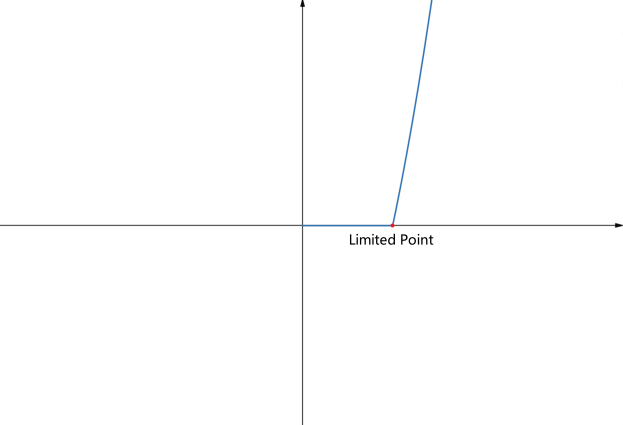

When the result of the constraint is less than the limit (4 in the current example), the constraint does not contribute a penalty value, but once the limit point is crossed, the penalty value will increase rapidly 😈.

It's quite a like a `ReLU` Function right ? Let's implement it with `Pytorch`, making sure the function is **differentiable**:

In [6]:
def penalty(outs: torch.Tensor) -> torch.Tensor:
    """This function is used to calculate the penalty term represented by eq.(2)

    Penalty Function: 2 x_1 + 1.7183 x_2 + 3 x_1 x_3 <= 4

    Args:
        outs:
            shape [4, 1], means 4 binary variables, items in {0,1}
    """
    p = 2 * torch.relu(2 * outs[0] + 1.7183 * outs[1] + 3 * outs[0] * outs[2] - 4)
    return p

you can also use other different mathematical formulas to express similar function curves, like:

$$ \begin{align}
f(p) = 
\begin{cases}
\ p^{2}\ -\ 16\ \  & \quad if \quad p>4 \\
\ 0 \ &\quad if \quad p \le 4
\end{cases}
\end{align} $$



#### Use our API

We provide some code to facilitate the management of multiple constraints (penalties):

In [7]:
from src import BaseConstraint, ConstraintManager


class ExamplePenalty(BaseConstraint):  # Inherited from this base class
    def compute_loss(self, outs, **kwargs):  # overrid this function
        p = torch.relu(2 * outs[0] + 1.7183 * outs[1] + 3 * outs[0] * outs[2] - 4)
        return p


cons_manager = ConstraintManager().add_constraint(ExamplePenalty(cons_items=[0, 1, 2],    # Index of variables involved in the operation
                                                                 coefficient=6,           # Penalty coefficient      
                                                                 expect=0,                # Expected Value
                                                                 name="example penalty")) # Constraint name

and use `loss_pubo_with_constraints` in `src/constraints.py` instead of `loss_pubo`:

In [8]:
from src import loss_pubo_with_constraints

layers = [Layer(LayerType.HGNNPCONV, 128, 64),      # Use HGNNP Layers to collect information
          Layer(LayerType.LINEAR, 64, 1)]           # Use Linear Layers for node state selection
X = torch.rand(data.num_v, 128)                     # model input

loss, outs = run(layers, X, data, 1250, loss_pubo_with_constraints, 1e-3, H=H, C=C, acl=acl, 
                 cons_manager=cons_manager)         # add our constraints manager
print("--------------------------------------------------------------------------------------------------")
state = cons_manager.is_valid(outs)                 # Check whether the result satisfies the constraint
print(f"\n\033[92moutput:{list(outs.cpu().squeeze().detach().numpy())}\033[0m")

 21%|██        | 264/1250 [00:02<00:09, 102.51it/s]

Epoch: 250 | Pubo Loss: -1.7550 | Constraint Loss: 0.00000000


 41%|████      | 513/1250 [00:05<00:08, 90.63it/s] 

Epoch: 500 | Pubo Loss: -1.8237 | Constraint Loss: 0.00000000


 61%|██████    | 764/1250 [00:07<00:04, 97.61it/s] 

Epoch: 750 | Pubo Loss: -1.8358 | Constraint Loss: 0.00000000


 81%|████████  | 1007/1250 [00:10<00:02, 96.59it/s]

Epoch: 1000 | Pubo Loss: -1.8399 | Constraint Loss: 0.00000000


100%|██████████| 1250/1250 [00:12<00:00, 98.10it/s] 

Epoch: 1250 | Pubo Loss: -1.8419 | Constraint Loss: 0.00000000
--------------------------------------------------------------------------------------------------
Constraint 'example penalty' PASS | Items: [0, 1, 2] | Coefficient: 6.00 | Outputs: [1, 1, 0] | Expect: 0 |Actual: 0.0 |

output:[0.99931693, 0.99845827, 0.091919646, 0.0003134595]


Comparing the results before and after adding constraints, in order to make the results meet the constraints, the model prefers to set $x_3$ to $0$ instead of $1$

> **Another way to think about constraints**
>
> In addition to the above method of turning constraints into additional terms attached to the PUBO formal formula, another highly discussed method is to convert each constraint into a hyperedge in the hypergraph structure (integrating the constraints into the PUBO polynomial), which may make better use of the powerful mechanism of graph neural networks, but the advantages and disadvantages of this method still need to be discussed.


## Practical application in Max-Cut problem on Hypergraph

### Formula derivation

The Max-Cut Problem on Hypergraph:

$$
O \ = \ \sum_{e\in E} \big( 1- \prod_{i \in e}x_i - \prod_{i \in e}(1-x_i)  \big)
$$

For each $\ e \ \text{in}\ E$ :

$$
O_e \ = \ 1 - \prod_{i \in e}{x_i} \ - \  \underbrace{\prod_{i \in e}{(1 - x_i)}}_{as \ T}
$$

For $\ T$ :

$$
T = {\textstyle \sum_{S\subseteq\normalsize{e}}}\  (-1)^{|S|} {\textstyle\prod_{i \in S}} \ x_i
$$

So :

$$
\begin{align}
O_e & = 1 - \prod_{i \in e}x_i - \big(1 - \sum_{i \in e}x_i + \sum_{i < j \in e}x_ix_j - \ ...\  + (-1)^{|e|} \prod_{i \in e}x_i \big) \\
    & = \underbrace{ \sum_{i \in e}x_i \  -\ \sum_{i < j \in e}x_ix_j + ...}_{as \ T'} - \underbrace{ \big( 1 + (-1)^{|e|}  \big) \prod_{i \in e}x_i }_{as \ Z}
\end{align}
$$




For $T'$ ,  
it is a classic problem: Find all the subsets of $ k(k < e) $ child elements in the set. We can solve it using a recursive backtracking method, see `generate_subsets` in `src/maxcut/utils.py`


Then for $Z$ ,  
 IF $|e|$ % 2 == 0 OR 1, the coefficient of $Z$ in $O_e$ should be -2 OR 0. However, for the sake of generality, we still keep polynomial terms with zero coefficients.
 
 
For example, if $e = \{x_1, x_2, x_3\}:$

$$
O_e = x_1 + x_2 + x_3 - x_1x_2 - x_1x_3 - x_2x_3 + 0 * x_1x_2x_3
$$

else if $e = \{x_1, x_2, x_3, x_4\}:$

$$
O_e = x_1 + x_2 + x_3 + x_4 - \sum_{i<j}x_ix_j + \sum_{i < j < k}x_ix_jx_k - 2x_1x_2x_3x_4
$$



So according to the derivation above, we have transformed the maxcut objective function on a hypergraph into the PUBO form, and guess what, according to the theory introduced in the previous section, we have reconstructed the maxcut-pubo form into a hypergraph structure and train this objective function with the help of graph neural networks!

> The key prerequisite for this transformation to take effect is that the variables in the maxcut objective function correspond one-to-one with the vertices in the maxcut-pubo-hypergraph, which also means that the source hypergraph corresponds one-to-one with the vertices of its maxcut-pubo-hypergraph.

### Run task

In [9]:
import os
from src.maxcut import build_hypergraph_maxcut
from src import from_file_to_hypergraph

cora_path = os.path.join(os.getcwd(), "../data/cora_hypergraph.txt")
data = from_file_to_hypergraph(cora_path, True).to(get_device())                                    # Instantiate a hypergraph structure from a file
data_maxcut_pubo_form = build_hypergraph_maxcut(source_hyperedge_list=data.e[0]).to(get_device())   # Construct the maxcut objective function of the target hypergraph as a hypergraph structure
H = data.H.to_dense()                                                                               # Get target hypergraph's incidence matrix for model forward
pubo_H = data_maxcut_pubo_form.H.to_dense()                                                         # Get maxcut-pubo-hypergraph's incidence matrix for pubo loss
C = torch.tensor(data_maxcut_pubo_form.e[1])                                                        # Get maxcut-pubo-hypergraph's hyperedge weight (terms' coefficients)

init_feature_dim = 1024 
layers = [
    Layer(LayerType.HGNNPCONV, init_feature_dim, 1024),
    Layer(LayerType.HGNNPCONV, 1024, 512, last_conv=True),
    Layer(LayerType.LINEAR, 512, 1, drop_rate=0.5),
]
X = torch.rand(data.num_v, init_feature_dim)
acl = lambda e : -1 + e / 1000

loss, outs = run(layers, X, data_maxcut_pubo_form , 1600, loss_pubo, 1e-4, H=H, C=C, acl=acl, pubo_H=pubo_H, clpi_grad=True)

 13%|█▎        | 204/1600 [00:07<00:48, 28.80it/s]

epoch: 200: loss:-1082.44 | annl: 1267.34


 25%|██▌       | 404/1600 [00:14<00:42, 28.36it/s]

epoch: 400: loss:-1154.88 | annl: 1169.49


 38%|███▊      | 602/1600 [00:21<00:35, 28.08it/s]

epoch: 600: loss:-1267.35 | annl: 952.92


 50%|█████     | 803/1600 [00:28<00:27, 28.58it/s]

epoch: 800: loss:-1375.39 | annl: 621.32


 63%|██████▎   | 1004/1600 [00:35<00:21, 27.44it/s]

epoch: 1000: loss:-1393.23 | annl: 474.66


 75%|███████▌  | 1205/1600 [00:42<00:13, 28.59it/s]

epoch: 1200: loss:-1393.83 | annl: 2.26


 88%|████████▊ | 1403/1600 [00:50<00:07, 28.00it/s]

epoch: 1400: loss:-1393.93 | annl: 0.60


100%|██████████| 1600/1600 [00:57<00:00, 27.76it/s]

epoch: 1600: loss:-1393.97 | annl: 0.26


> You can observe that we have employed only a simple neural network for algorithm verification, while other advanced architectures such as ResNet and GRU were not utilized in our work. Although these could potentially enhance the quality of solutions, our primary contribution lies in proposing a novel approach for solving integer programming problems.

### Evaluate Results

We have implemented an evaluation function for each task: `src/maxcut/maxcut_evaluate`, it can evaluate the results of the model, and you can check some information in the dictionary type it returns:

In [10]:
from src.maxcut import maxcut_evaluate
maxcut_evaluate(outs, data)

{'cut_edges': 1394,
 'total_edges': 1413,
 'accuracy': 0.9865534324133051,
 'group_distribution': (678, 652),
 'not_converged': 0}

It means that the model's result indicates that there are `1394` cut edges with `1413` total edges, and `0` vertices that do not converge (with a default tolerance of $0.7$, meaning results between $0.3$ and $0.7$ are considered non-convergent and the expectation is $\lbrace 0, 1 \rbrace$), well, the results of this experiment are even better than those in the paper 👍

## Using other algorithms for comparison

We provide `SCIP` `Tabu` as the main comparative experiments for our work, you can easily use them through our code:

In [12]:
# Use Tabu to solve maxcut problem on hypergraph:Cora
from src import solve_pubo_with_tabu
cora_path = os.path.join(os.getcwd(), "../data/cora_hypergraph.txt")
data = from_file_to_hypergraph(cora_path, True).to(get_device()) 
data_maxcut_pubo_form = build_hypergraph_maxcut(source_hyperedge_list=data.e[0])
H=data_maxcut_pubo_form.H.to_dense()
C=torch.tensor([data_maxcut_pubo_form.e[1]])
_, cuts = solve_pubo_with_tabu(data_maxcut_pubo_form.num_v, data_maxcut_pubo_form.num_e, H=H.cpu(), C=C.cpu())
cuts

-1360.0

In [ ]:
# Use scip to solve maxcut problem on hypergraph:Cora
# it takes 1 hour least, result see our paper :)
from src import solve_pubo_with_scip
cora_path = os.path.join(os.getcwd(), "../../data/cora_hypergraph.txt")
data = from_file_to_hypergraph(cora_path, True).to(get_device()) 
data_maxcut_pubo_form = build_hypergraph_maxcut(source_hyperedge_list=data.e[0])
H=data_maxcut_pubo_form.H.to_dense()
C=torch.tensor([data_maxcut_pubo_form.e[1]])
solve_pubo_with_scip(data_maxcut_pubo_form.num_v, data_maxcut_pubo_form.num_e, H=H.cpu(), C=C.cpu())

Thank you! 🫡